In [98]:
import pandas as pd

CRIME_DATA = 'Crime_Data_from_2020_to_Present.csv'
ACTIVE_BUSINESSES = 'Listing_of_Active_Businesses.csv'
ALL_CLOSED_BUSINESSES = 'All_Closed_Businesses.csv'

LOS_ANGELES_PLANNING_AREAS = 'LosAngeles_Community_Planning_Areas__CPA.json'

In [99]:
import pyproj

# Define the EPSG codes for WGS 84 (lat/lon) and EPSG 3857 (Web Mercator)
wgs84 = pyproj.CRS("EPSG:4326")
web_mercator = pyproj.CRS("EPSG:3857")

# Create a pyproj transformer
transformer = pyproj.Transformer.from_crs(wgs84, web_mercator, always_xy=True)

# Define your latitude and longitude
lat = 34.0000
lon = -118.0000

# Transform the coordinates to EPSG:3857
x, y = transformer.transform(lon, lat)

print(f"EPSG:3857 (Web Mercator) coordinates: x={x}, y={y}")

EPSG:3857 (Web Mercator) coordinates: x=-13135699.913606282, y=4028802.026134408


In [100]:
def transform_coordinates(longitude, latitude):
    """Transforms the coordinates of a row to EPSG:3857"""
    return transformer.transform(longitude, latitude)

In [101]:
import random


def generate_random_hex_color():
    # Generate random values for Red, Green, and Blue in the range [0, 255]
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)

    # Convert the RGB values to a hexadecimal color code
    hex_color = "#{:02X}{:02X}{:02X}".format(red, green, blue)

    return hex_color

The point is within the feature with NAME_ALF: Hollywood
The point is not within any of the features.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


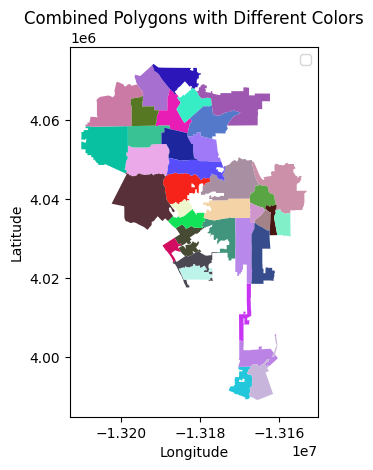

In [102]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import shape, Point

# Load the GeoJSON data
with open(f'data/{LOS_ANGELES_PLANNING_AREAS}', 'r') as f:
    data = json.load(f)

# Define the latitude and longitude of the point you want to check
lat, lon = transform_coordinates(-118.3012685, 34.1094992)

los_angeles_map = []

# Create a Point object for the given lat and lon
point = Point(lat, lon)
los_angeles_map.append(gpd.GeoSeries(point))

# Iterate through the features in the GeoJSON file
for feature in data['features']:
    polygon = shape(feature['geometry'])
    los_angeles_map.append(gpd.GeoSeries(polygon))
    if polygon.contains(point):
        properties = feature['properties']
        print(f"The point is within the feature with NAME_ALF: {properties['NAME_ALF']}")
else:
    print("The point is not within any of the features.")

ax = None
for i, gdf in enumerate(los_angeles_map):
    # Plot each GeoDataFrame with a different color
    ax = gdf.plot(ax=ax, color=generate_random_hex_color())

# Customize the plot (optional)
ax.set_title("Combined Polygons with Different Colors")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Show the plot
plt.show()

In [103]:
def get_community_planning_area(longitude, latitude) -> str:
    """Returns the community planning area for a given latitude and longitude"""
    # Transform the coordinates to EPSG:3857
    x, y = transform_coordinates(longitude, latitude)

    # Create a Point object for the given lat and lon
    point = Point(x, y)

    # Iterate through the features in the GeoJSON file
    for feature in data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            properties = feature['properties']
            return f"{properties['NAME_ALF']}-{properties['Acronym']}"
    else:
        return '_NOT FOUND_'

In [104]:
crime_df = pd.read_csv(f'data/{CRIME_DATA}', usecols=['DR_NO', 'AREA', 'AREA NAME', 'LOCATION', 'LAT', 'LON'])
crime_df

,DR_NO,AREA,AREA NAME,LOCATION,LAT,LON
0,10304468,3,Southwest,1100 W 39TH PL,34.0141,-118.2978
1,190101086,1,Central,700 S HILL ST,34.0459,-118.2545
2,200110444,1,Central,200 E 6TH ST,34.0448,-118.2474
3,191501505,15,N Hollywood,5400 CORTEEN PL,34.1685,-118.4019
4,191921269,19,Mission,14400 TITUS ST,34.2198,-118.4468
...,...,...,...,...,...,...
829773,231604807,16,Foothill,12500 BRANFORD ST,34.2466,-118.4054
829774,231606525,16,Foothill,12800 FILMORE ST,34.2790,-118.4116
829775,231210064,12,77th Street,6100 S VERMONT AV,33.9841,-118.2915
829776,230115220,1,Central,500 S MAIN ST,34.0467,-118.2485


In [ ]:
import time

start_time = time.time()

for row in crime_df.itertuples():
    if row.Index % 1000 == 0:
        print(f"{row.Index} rows processed in {time.time() - start_time} seconds")

    # Skip rows that don't have a latitude or longitude value (i.e. 0.0)
    if row.LON == 0.0 or row.LAT == 0.0:
        print(f"Skipping row {row.Index} because it has invalid coordinates ({row.LON}, {row.LAT})")
        crime_df.at[row.Index, 'COMMUNITY PLANNING AREA'] = '_INVALID_'
        continue

    # Get the community planning area for the given latitude and longitude
    community_planning_area = get_community_planning_area(row.LON, row.LAT)

    # Add the community planning area to the DataFrame
    crime_df.at[row.Index, 'COMMUNITY PLANNING AREA'] = community_planning_area

    # Print a message if the community planning area could not be found
    if community_planning_area == '_NOT FOUND_':
        print(f"Could not find a community planning area for the coordinates ({row.LON}, {row.LAT})")

crime_df

0 rows processed in 0.0003268718719482422 seconds
1000 rows processed in 34.82686376571655 seconds
Skipping row 1403 because it has invalid coordinates (0.0, 0.0)
2000 rows processed in 60.7174928188324 seconds
Skipping row 2108 because it has invalid coordinates (0.0, 0.0)
Could not find a community planning area for the coordinates (-118.372, 34.0301)
Could not find a community planning area for the coordinates (-118.3708, 34.0325)
3000 rows processed in 84.95070099830627 seconds
Skipping row 3157 because it has invalid coordinates (0.0, 0.0)
Could not find a community planning area for the coordinates (-118.3092, 33.8365)
Could not find a community planning area for the coordinates (-118.1922, 34.0166)
Could not find a community planning area for the coordinates (-118.1922, 34.0189)
Could not find a community planning area for the coordinates (-118.1574, 34.0955)
4000 rows processed in 108.94972276687622 seconds
Could not find a community planning area for the coordinates (-118.1574

In [ ]:
active_business_df = pd.read_csv(
    f'data/{ACTIVE_BUSINESSES}',
    usecols=['BUSINESS NAME', 'CITY', 'LOCATION'],
    dtype={'LOCATION': str},
)

active_business_df

In [ ]:
active_business_df = active_business_df[active_business_df["CITY"] == "LOS ANGELES"]
active_business_df

In [ ]:
import time

start_time = time.time()

for row in active_business_df.itertuples():
    if row.Index % 1000 == 0:
        print(f"{row.Index} rows processed in {time.time() - start_time} seconds")

    if pd.isna(row.LOCATION):
        print(f"Skipping row {row.Index} because it has missed coordinates")
        active_business_df.at[row.Index, 'COMMUNITY PLANNING AREA'] = '_INVALID_'
        continue

    # Remove the parentheses and split the string into latitude and longitude
    lat_lon_list = row.LOCATION.strip("()").split(", ")

    # Get the community planning area for the given latitude and longitude
    community_planning_area = get_community_planning_area(float(lat_lon_list[1]), float(lat_lon_list[0]))

    # Add the community planning area to the DataFrame
    active_business_df.at[row.Index, 'COMMUNITY PLANNING AREA'] = community_planning_area

    # Print a message if the community planning area could not be found
    if community_planning_area == '_NOT FOUND_':
        print(f"Could not find a community planning area for the coordinates {row.LOCATION}")

active_business_df